In [1]:
import json
import pandas as pd
import datetime
import matplotlib.pyplot as plt
plt.style.use(['ggplot'])

### Plot utils

In [2]:
def get_key_round(df,round_list=[6,11,16,21,26]):
#     获取每一个关键交易轮的timeid
    df = df.set_index('time').sort_index()
    df.index = pd.to_datetime(df.index)
    round_realse = []
    for i in round_list:
#         print(i)
        realse1= df[df['round']==i].index[0]
        round_realse.append(realse1)
    return round_realse

def get_role_data(all_user,role):
    df = all_user[all_user['role']==role]
    df = df.set_index('time').sort_index()
    df.index = pd.to_datetime(df.index)
        
    return df


def plot_buy_sell(df,x_positions,target='target',is_fair=False, title='example'):
    plt.figure(figsize = (10,6))
    plt.plot(df['buy'],label='buy price')
    plt.plot(df['sell'], label = 'sell price')
    if is_fair:
        plt.plot(df[target]*100,label='Fair Price')
        
    plt.legend()

    max_price = max(df['buy'].astype(int).max(), df['sell'].astype(int).max())
    
    label = 1
    for i in x_positions:
        label += 5
        plt.axvline(x=i, color='gray', linestyle='--')  # 红色虚线
        plt.text(i, max_price * 0.95, f'Round {label}', rotation=0, horizontalalignment='center')

    plt.title(f'{title} ')
    plt.xlabel('Time')
    plt.ylabel('Trade Prices')
    plt.savefig(f'data/plot/{title}.png')
    plt.show()
    

def plot_buy_sell_subplots(dfs, x_positions, target_list,title='full_plots'):
    fig, axs = plt.subplots(2, 2, figsize=(20, 12))  # 创建一个2x2子图的图形
    axs = axs.flatten()  # 将子图数组转换为一维数组，便于迭代
    
    for i in range(0,4):  # 同时迭代axes和dataframes
        df = dfs[i]
        ax = axs[i]
        target= target_list[i]
        max_price = max(df['buy'].max(), df['sell'].max())
        ax.plot(df['buy'], label='Buy Price')
        ax.plot(df['sell'], label='Sell Price')
        ax.plot(df[target]*100, label='Fair Price')
        ax.legend()

        label = 1
        for i in x_positions:
            label += 5
            ax.axvline(x=i, color='gray', linestyle='--')  # 添加灰色虚线
            ax.text(i, max_price * 0.95, f'Round {label}', rotation=0, horizontalalignment='center')

        ax.set_title(f'Prices of {target}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Trade Prices')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 调整子图间距，为整体标题留出空间
    fig.suptitle(title)  # 设置整体标题
    plt.tight_layout()  # 调整子图间距
    plt.savefig(f'data/plot/{title}_subplots.png')
    plt.show()


### 数据预处理

In [3]:
def get_trades_records(data1):
    final_df = pd.DataFrame()
    for i in range(0,len(data1['trades'])):
        trade = pd.DataFrame(data1['trades'][i],index=[0])
        final_df = pd.concat([final_df,trade])

    final_df['time'] = pd.to_datetime(final_df['created_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
    return final_df 

def process_data(data1):
    all_user = pd.DataFrame()
    hand_df = pd.DataFrame()
    revealed_df =  pd.DataFrame()
    for i in range(0,len(data1['players']['data'])):
        data = data1['players']['data'][i]
        data_role = data['role']
        data_log = data['rate_change_log']

        hand = pd.DataFrame(data['hand'],index=[data_role])
        hand_df = pd.concat([hand_df,hand])

        revealed = pd.DataFrame(data['revealed'],index=[data_role])
        revealed_df = pd.concat([revealed_df,revealed])

        user_data = pd.DataFrame(data_log)
        user_data['role'] = data_role
        all_user=pd.concat([all_user,user_data])

    all_user['time'] = pd.to_datetime(all_user['time'], unit='ms', utc=True)   
    all_user['time'] = all_user['time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    all_user['buy'] = all_user['buy'].astype(str).str.lstrip('0').str.pad(width=1, side='left', fillchar='0').astype(int)
    all_user['sell'] = all_user['sell'].astype(str).str.lstrip('0').str.pad(width=1, side='left', fillchar='0').astype(int)
    all_user['round'] = all_user['round'].astype(int)
    all_user = all_user.reset_index(drop='True')
    return all_user,hand_df,revealed_df


# 如何计算概率呢？
def get_phy_prob(target, market_maker):
    prob = (13 - market_maker[target]) / (52 - market_maker['diamonds'] - market_maker['spades'] - market_maker['hearts'] - market_maker['clubs'])
    return round(prob,2)

# 获取私人的概率
def get_private_phy_prob(target, final_info):
    prob = (13 - final_info[target]) / (52 - final_info['diamonds'] - final_info['spades'] - final_info['hearts'] - final_info['clubs'])
    return round(prob,2)

def get_revealed_data(revealed_df,round_n,market_maker):
    round_n = str(round_n)
    for maker in revealed_df[round_n].value_counts().index:
        market_maker[maker] = market_maker[maker] + revealed_df[round_n].value_counts()[maker]
    return market_maker

def check_private_info(revealed_info,private_info,market_maker):
        final_info = {}
        realses_point = revealed_info.pop(0)
        private_info[realses_point] = private_info[realses_point] - 1 
        for key, values in market_maker.items():
            final_info[key] = market_maker[key] + private_info[key]
        return private_info,final_info

def check_category(now_revealed , market_maker):
    market_maker[now_revealed] = market_maker[now_revealed] +1

    return market_maker
    
    
def update_prob_and_value(i,
                          revealed_df,
                          market_maker,
                          revealed_info,
                          deck_data,
                          final_info,
                          private_info):

    if i == 1:
        market_maker = get_revealed_data(revealed_df,i,market_maker)
        private_info,final_info = check_private_info(revealed_info,private_info,market_maker)
    elif i == 6:
        market_maker = get_revealed_data(revealed_df,i,market_maker)
        private_info,final_info = check_private_info(revealed_info,private_info,market_maker)
    elif i == 11:
        market_maker = get_revealed_data(revealed_df,i,market_maker)
        private_info, final_info = check_private_info(revealed_info,private_info,market_maker)
    elif i == 16:
        market_maker = get_revealed_data(revealed_df,i,market_maker)
        private_info,final_info = check_private_info(revealed_info,private_info,market_maker)
    elif i == 21:
        market_maker = get_revealed_data(revealed_df,i,market_maker)
        private_info,final_info = check_private_info(revealed_info,private_info,market_maker)
    elif i == 26:
        market_maker = get_revealed_data(revealed_df,i,market_maker)
        private_info,final_info = check_private_info(revealed_info,private_info,market_maker)
    else:
        now_revealed = deck_data.pop(0)
        market_maker = check_category(now_revealed,market_maker)
        final_info = check_category(now_revealed,final_info)
    return final_info,market_maker,private_info



def generate_sum_of_market(all_user):
    # 假定的角色列表
    roles = ['diamonds', 'hearts', 'clubs', 'spades']
    test_user = all_user.copy()
    # 生成所有时间点和角色的组合
    all_combinations = pd.MultiIndex.from_product([test_user['time'].unique(), roles], names=['time', 'role'])

    # 将原始DataFrame转换为MultiIndex格式，以便合并
    test_user.set_index(['time', 'role'], inplace=True)
    # 创建一个完整组合的DataFrame，这将包括所有可能的时间点和角色组合
    full_df = pd.DataFrame(index=all_combinations).reset_index()
    # 合并原始数据，对于缺失的组合填充NaN
    full_df = full_df.merge(all_user, on=['time', 'role'], how='left')
    full_df = full_df[['time','role','buy','sell']]


#     print(full_df)
    # 按角色和时间排序
    full_df.sort_values(by=['role', 'time'], inplace=True)

    # 对每个角色分组并前向填充
    full_df = full_df.groupby('role').apply(lambda group: group.ffill()).reset_index(drop=True)

    # 如果需要，再按时间对整个DataFrame进行排序
    full_df.sort_values(by='time', inplace=True)

    sum_prices = full_df.groupby(['time'])[['buy','sell']].sum()
    sum_prices.index = pd.to_datetime(sum_prices.index)

    return full_df,sum_prices

### 数据读取 

In [4]:
# 从网站爬取的数据 里面有很多数据 包括每一个market maker设置的价差变化
with open('data/final_info.json', 'r') as file:
    file = json.load(file)
    data1 = file[-1]

# #  下载的用户交易记录
actor_name = pd.read_csv('data/trade2.csv')
actor_name = actor_name[['actor id','actor']]
actor_name.columns =  ['actor','user']

In [5]:
# 获取用户价差变化
all_user,hand_df,revealed_df = process_data(data1)
# 获取用户交易记录
df = get_trades_records(data1)
df = df.reset_index(drop=True)

In [6]:
df = pd.concat([df,actor_name],axis=1)

In [7]:
df

,created_at,market,price,type,actor,game_id,round,id,time,actor,user
0,2024-02-22T18:58:55.064043+00:00,diamonds,48,sell,dc16afcd-8787-45fd-8921-a531ec0cefa1,op-PyjkPu7rO,32,fd13d1d8-19e0-4fc9-8164-86bd87aff2f6,2024-02-22 18:58:55,xin,hearts
1,2024-02-22T18:58:53.72578+00:00,hearts,44,sell,dc16afcd-8787-45fd-8921-a531ec0cefa1,op-PyjkPu7rO,32,bbd04115-5ffe-422a-9702-f9db43172d11,2024-02-22 18:58:53,Ronald,clubs
2,2024-02-22T18:58:53.664751+00:00,hearts,44,sell,f6ee3ebc-f691-4e17-9b78-a22488bdaa2e,op-PyjkPu7rO,32,50d45a1b-344f-4de0-bf3f-a1f1d28cbc69,2024-02-22 18:58:53,Ronald,clubs
3,2024-02-22T18:58:53.486311+00:00,hearts,46,buy,6c314841-1137-4f22-8285-53b02057ee8f,op-PyjkPu7rO,32,2bb76edc-a0f4-409e-b73d-928d07d24a29,2024-02-22 18:58:53,Yimeng,clubs
4,2024-02-22T18:58:51.93565+00:00,diamonds,48,sell,dc16afcd-8787-45fd-8921-a531ec0cefa1,op-PyjkPu7rO,32,ef062166-0bc0-4d30-a261-8964bb166443,2024-02-22 18:58:51,Ronald,clubs
...,...,...,...,...,...,...,...,...,...,...,...
2520,2024-02-22T18:08:36.305542+00:00,spades,30,buy,6c314841-1137-4f22-8285-53b02057ee8f,op-PyjkPu7rO,1,d4d02242-73ed-43f7-ba02-337f3fbd01d7,2024-02-22 18:08:36,NaN,NaN
2521,2024-02-22T18:08:35.34374+00:00,clubs,24,sell,6c314841-1137-4f22-8285-53b02057ee8f,op-PyjkPu7rO,1,f9c253cc-43f5-41c1-ab7a-92677f6256e1,2024-02-22 18:08:35,NaN,NaN
2522,2024-02-22T18:08:33.700149+00:00,spades,30,buy,6c314841-1137-4f22-8285-53b02057ee8f,op-PyjkPu7rO,1,6ddda0c9-a3b3-4b2e-82dd-13766a21e68e,2024-02-22 18:08:33,NaN,NaN
2523,2024-02-22T18:08:33.468554+00:00,spades,24,sell,dc16afcd-8787-45fd-8921-a531ec0cefa1,op-PyjkPu7rO,1,34f26af5-e3df-40b0-951e-e3e350ef07cb,2024-02-22 18:08:33,NaN,NaN


In [8]:
revealed_df = revealed_df[-4:]

In [9]:
revealed_df

,1,6,11,16,21,26
diamonds,hearts,hearts,diamonds,clubs,clubs,clubs
spades,clubs,hearts,clubs,clubs,diamonds,hearts
hearts,diamonds,hearts,clubs,diamonds,diamonds,diamonds
clubs,clubs,clubs,spades,spades,spades,spades


In [17]:
# 自己的身份
private_maker = 'clubs'

# 初始化市场
market_maker = {'diamonds':0,
               'spades':0,
               'hearts':0,
               'clubs':0}
# 获取公开信息
deck_data = data1['game']['deck']['revealed'].copy()

# 私有信息的所有
private_info = hand_df.loc[private_maker].to_dict()
# 每次pop出哪个信息
revealed_info = revealed_df.loc[private_maker].tolist().copy()

private_prob_list = []
prob_public_list = []
final_info ={}
for i in range(1,34,1):
    print(f'----------iteration {i}------------')
    final_info,market_maker,private_info = update_prob_and_value(i,
                                                                 revealed_df,
                                                                 market_maker,
                                                                 revealed_info,
                                                                 deck_data,
                                                                 final_info,
                                                                 private_info)
     
    # 基于素有公开消息的probably
    prob_clubs = get_phy_prob ('clubs',market_maker)
    prob_diamonds= get_phy_prob ('diamonds', market_maker)
    prob_spades = get_phy_prob ('spades', market_maker)
    prob_hearts = get_phy_prob ('hearts', market_maker)
    
    # 结合自己的私有新的probably
    private_prob_clubs = get_private_phy_prob('clubs', final_info)
    private_prob_diamonds = get_private_phy_prob('diamonds', final_info)
    private_prob_spades = get_private_phy_prob('spades', final_info)
    private_prob_hearts = get_private_phy_prob('hearts', final_info)
#     print(market_maker)
    print(final_info)
    
    print('*******public********')
    print(f'prob_club: {prob_clubs}')
    print(f'prob_diamonds: {prob_diamonds}')
    print(f'prob_spades: {prob_spades}')
    print(f'prob_hearts: {prob_hearts}')
    print('*******private*******')
    print(f'private_prob_clubs:{private_prob_clubs}')
    print(f'private_prob_diamonds:{private_prob_diamonds}')
    print(f'private_prob_spades:{private_prob_spades}')
    print(f'private_prob_hearts:{private_prob_hearts}')
    
    prob_public_data = pd.DataFrame({'round':i
                        ,'hearts':prob_hearts,
                         'spades':prob_spades,
                         'diamonds':prob_diamonds,
                         'clubs':prob_clubs},
                        index=[0])
    
    
    prob_data = pd.DataFrame({'round':i
                            ,'hearts':private_prob_hearts,
                             'spades':private_prob_spades,
                             'diamonds':private_prob_diamonds,
                             'clubs':private_prob_clubs},
                            index=[0])
    private_prob_list.append(prob_data)
    prob_public_list.append(prob_public_data)

private_prob_df = pd.concat(private_prob_list).reset_index(drop=True)
public_prob_df = pd.concat(prob_public_list).reset_index(drop=True)

----------iteration 1------------
{'diamonds': 1.0, 'spades': 4.0, 'hearts': 1.0, 'clubs': 3.0}
*******public********
prob_club: 0.23
prob_diamonds: 0.25
prob_spades: 0.27
prob_hearts: 0.25
*******private*******
private_prob_clubs:0.23
private_prob_diamonds:0.28
private_prob_spades:0.21
private_prob_hearts:0.28
----------iteration 2------------
{'diamonds': 2.0, 'spades': 4.0, 'hearts': 1.0, 'clubs': 3.0}
*******public********
prob_club: 0.23
prob_diamonds: 0.23
prob_spades: 0.28
prob_hearts: 0.26
*******private*******
private_prob_clubs:0.24
private_prob_diamonds:0.26
private_prob_spades:0.21
private_prob_hearts:0.29
----------iteration 3------------
{'diamonds': 2.0, 'spades': 4.0, 'hearts': 2.0, 'clubs': 3.0}
*******public********
prob_club: 0.24
prob_diamonds: 0.24
prob_spades: 0.28
prob_hearts: 0.24
*******private*******
private_prob_clubs:0.24
private_prob_diamonds:0.27
private_prob_spades:0.22
private_prob_hearts:0.27
----------iteration 4------------
{'diamonds': 2.0, 'spades':

In [18]:
public_prob_df.columns = ['round','public_hearts','public_spades','public_diamonds','public_clubs']

round_realse = get_key_round(all_user,round_list=[6,11,16,21,26])
all_user_new = pd.merge(all_user,public_prob_df)
all_user_new = pd.merge(all_user_new,private_prob_df)

diamonds= get_role_data(all_user_new,'diamonds')
spades= get_role_data(all_user_new,'spades')
hearts= get_role_data(all_user_new,'hearts')
clubs= get_role_data(all_user_new,'clubs')

In [19]:
def plot_private_info_influence(df,target,public_target):
    plt.figure(figsize = (10,6))
    plt.plot(df['buy'],label='buy price')
    plt.plot(df['sell'], label = 'sell price')

    plt.plot(df[target]*100,label='Private Fair Price')
    plt.plot(df[public_target]*100,label='Public Fair Price')

    plt.legend()

    max_price = max(df['buy'].astype(int).max(), df['sell'].astype(int).max())

    label = 1
    for i in round_realse:
        label += 5
        plt.axvline(x=i, color='gray', linestyle='--')  # 红色虚线
        plt.text(i, max_price * 0.95, f'Round {label}', rotation=0, horizontalalignment='center')

    plt.xlabel('Time')
    plt.ylabel('Trade Prices')
    plt.title('Fair Price and Private Fair Price for diamonds')

    plt.show()

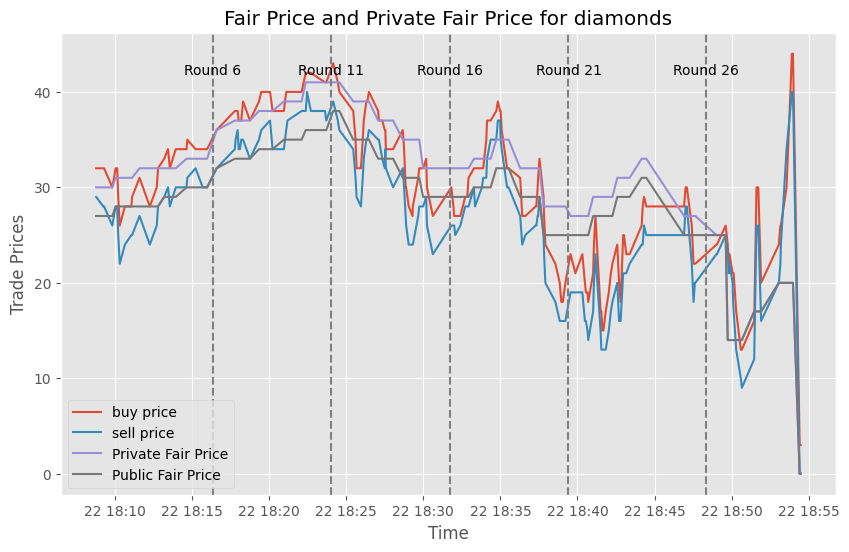

In [13]:
plot_private_info_influence(spades,'spades','public_spades')

In [14]:
# plot_buy_sell(diamonds,round_realse,'diamonds',title='diamonds')
# plot_buy_sell(spades,round_realse,'spades',title='spades')
# plot_buy_sell(hearts,round_realse,'hearts',title='hearts')
# plot_buy_sell(clubs,round_realse,'clubs',title='clubs')


In [20]:
dfs = [clubs, hearts, spades, diamonds]
target = ['clubs', 'hearts', 'spades', 'diamonds']

C:\Users\xinzhan\AppData\Local\Temp\ipykernel_30976\2086768003.py:69: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # 调整子图间距


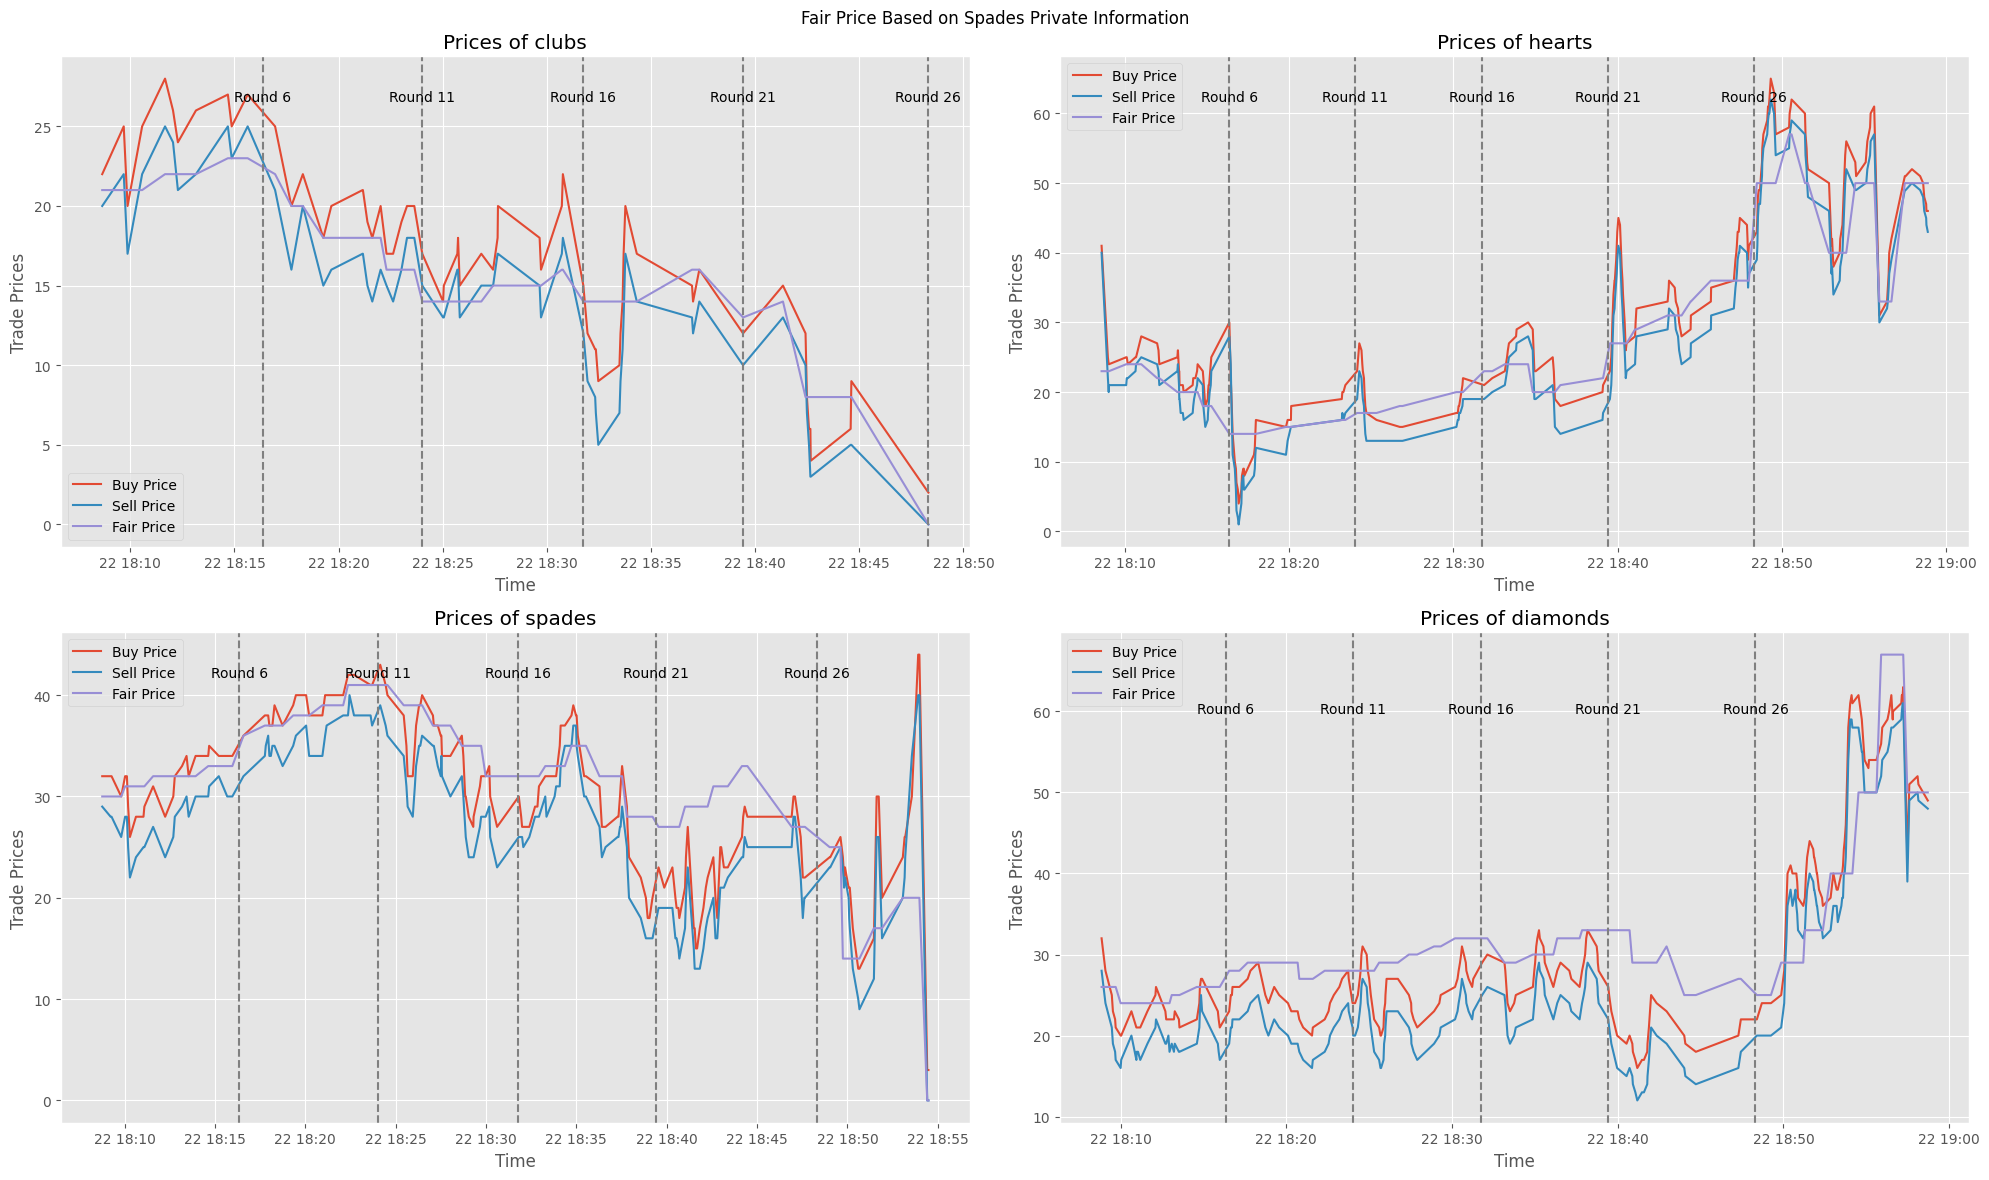

In [15]:
plot_buy_sell_subplots(dfs, round_realse,target,title='Fair Price Based on Spades Private Information')

C:\Users\xinzhan\AppData\Local\Temp\ipykernel_36604\2086768003.py:69: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # 调整子图间距


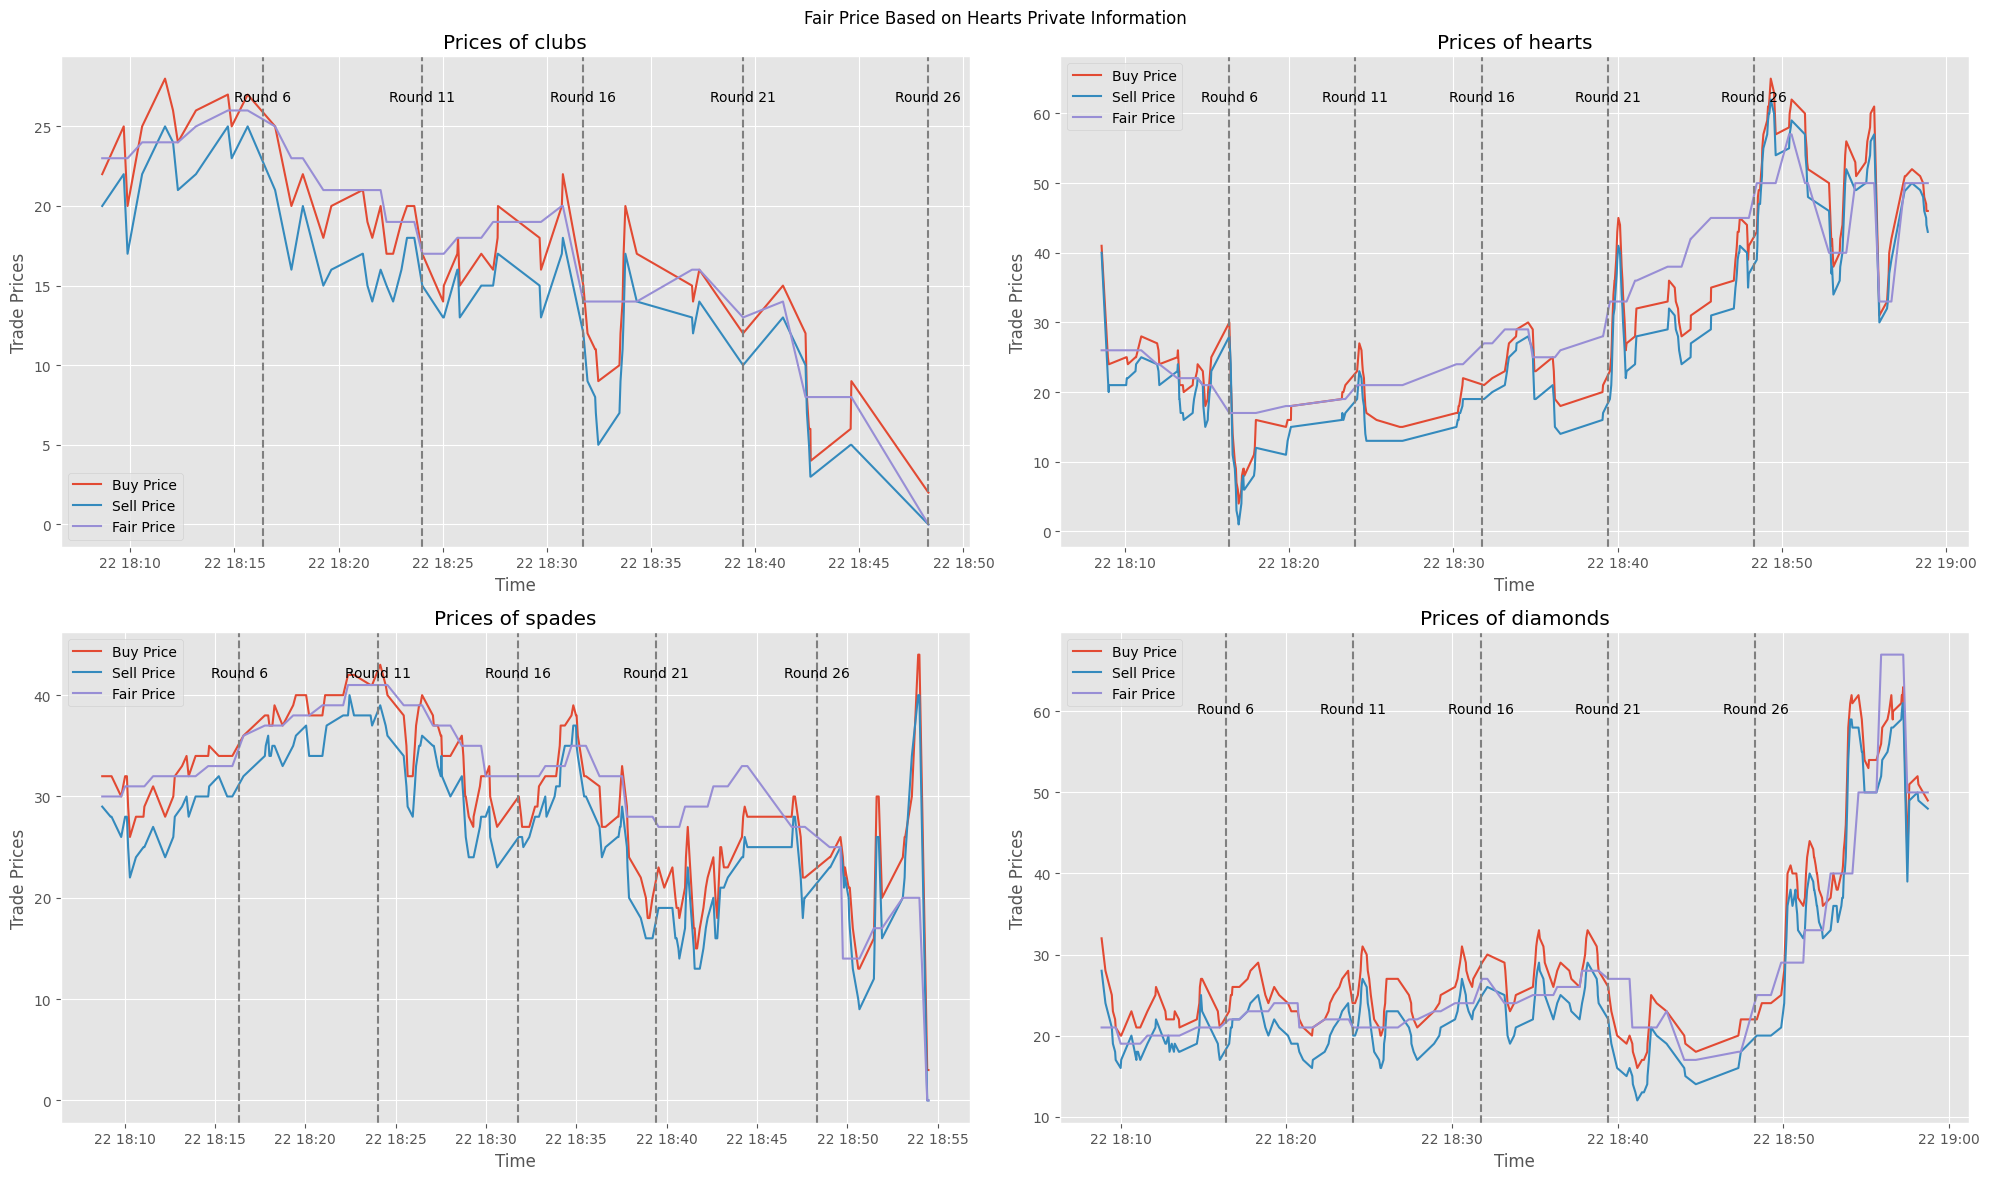

In [15]:
plot_buy_sell_subplots(dfs, round_realse,target,title='Fair Price Based on Hearts Private Information')

C:\Users\xinzhan\AppData\Local\Temp\ipykernel_28416\2086768003.py:69: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # 调整子图间距


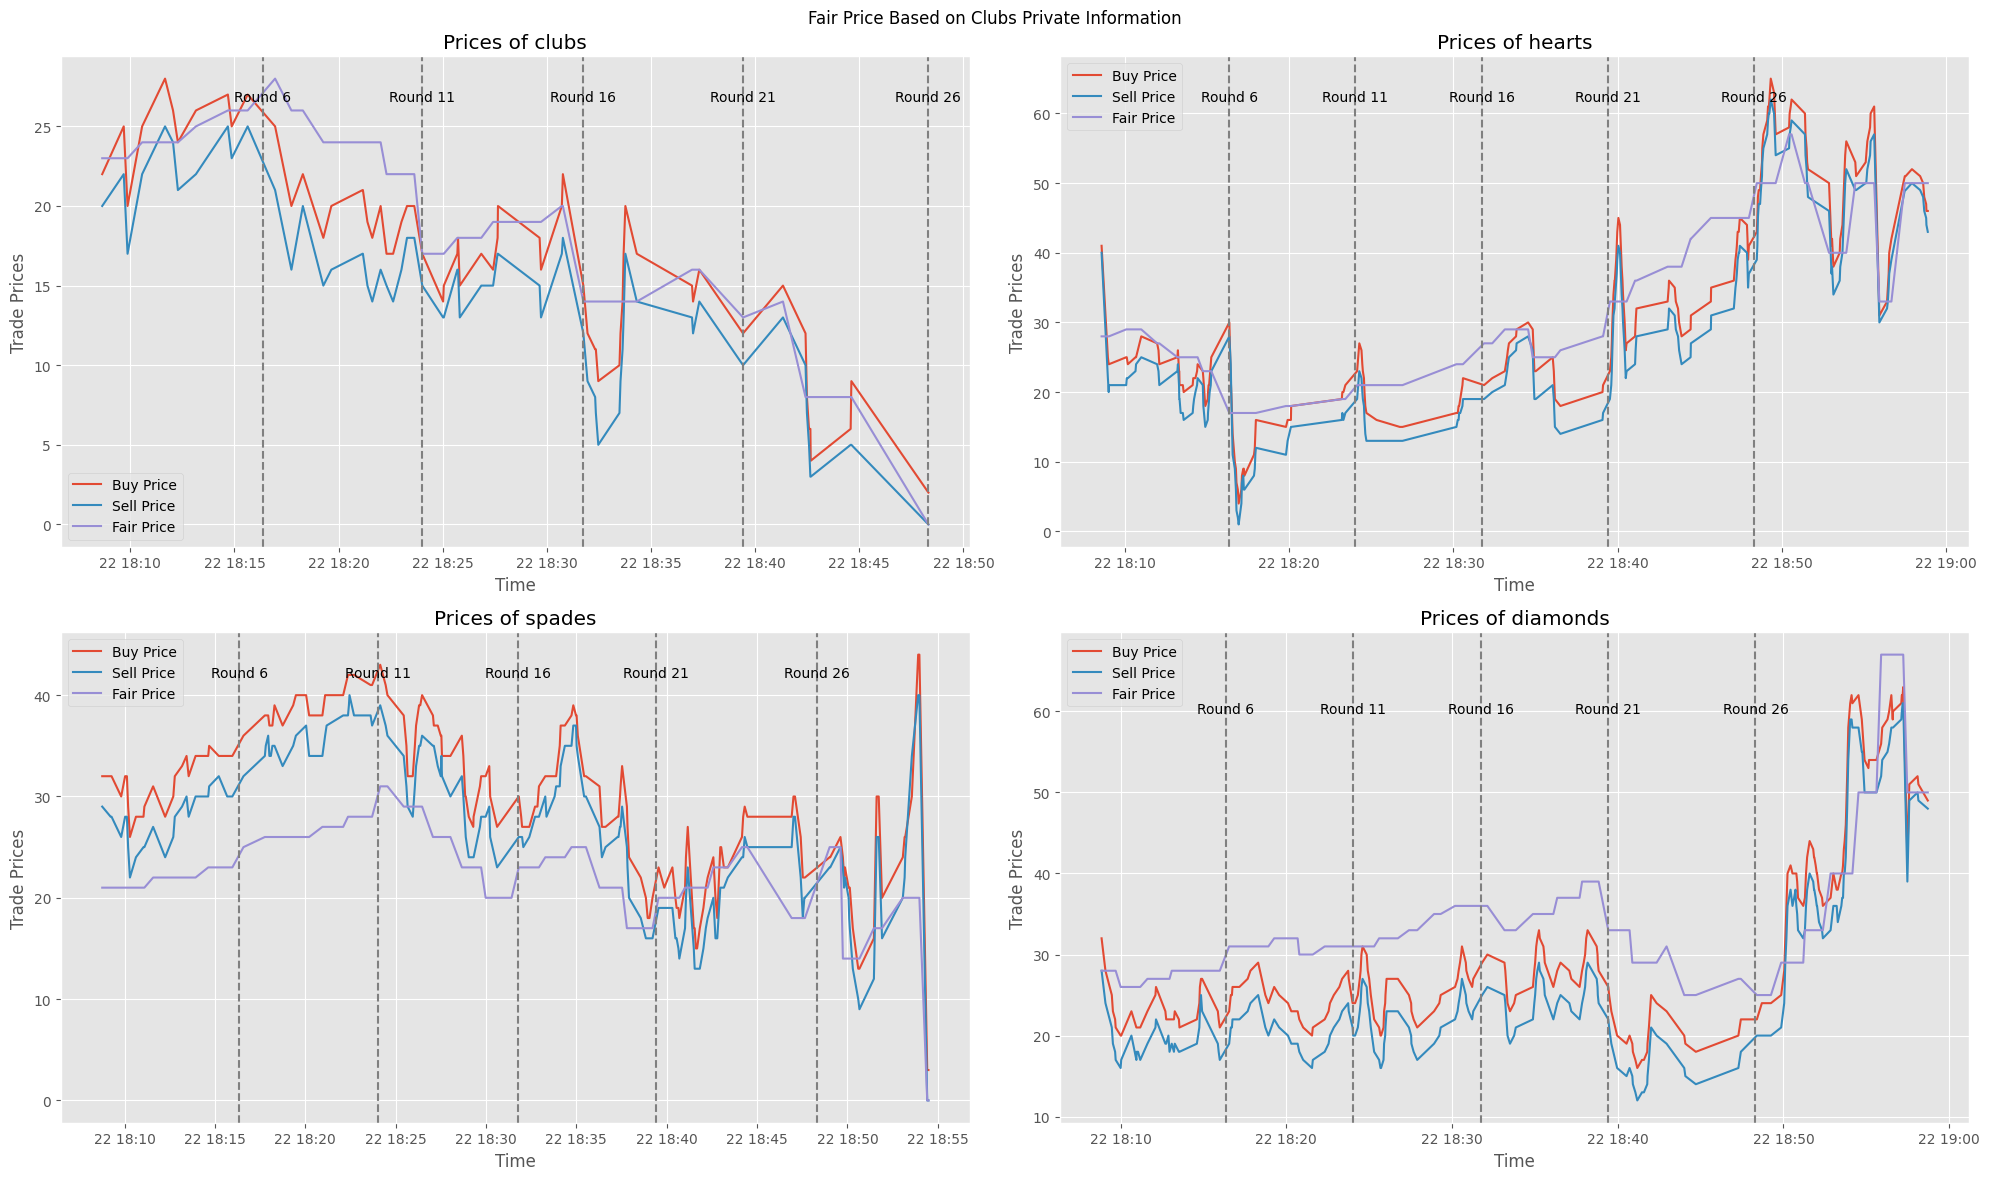

In [21]:
plot_buy_sell_subplots(dfs, round_realse,target,title='Fair Price Based on Clubs Private Information')

C:\Users\xinzhan\AppData\Local\Temp\ipykernel_28416\2086768003.py:69: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # 调整子图间距


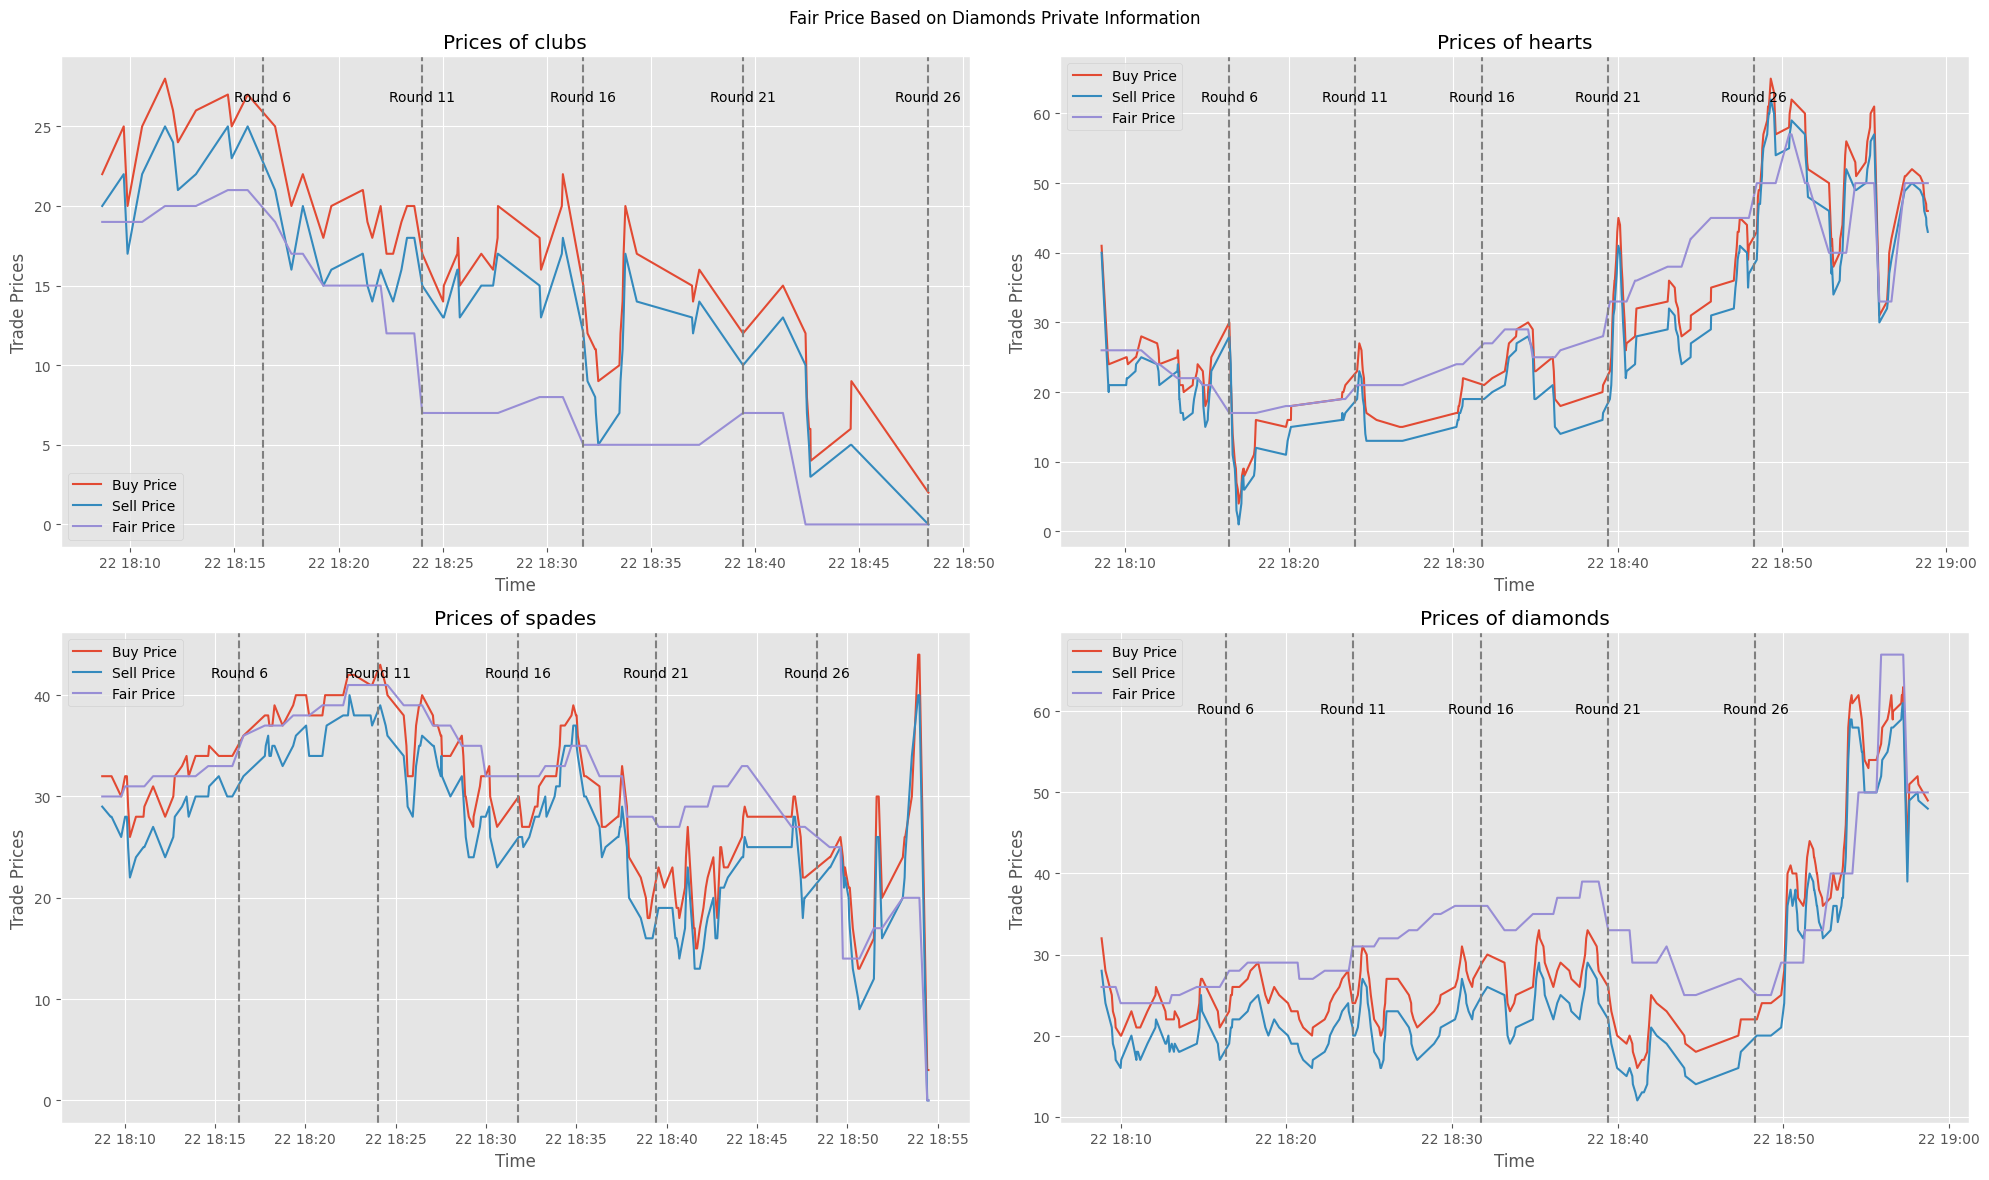

In [16]:
plot_buy_sell_subplots(dfs, round_realse,target,title='Fair Price Based on Diamonds Private Information')

In [ ]:
plot_buy_sell(clubs,round_realse,'clubs',True,title='clubs')

###  如何画出市场每个时间点ask 以及bid之和？

In [ ]:
full_df, sum_prices = generate_sum_of_market(all_user)

In [ ]:
plot_buy_sell(sum_prices,round_realse,title='The Sum value of The Market')

## 用户交易数据 

###  market maker的价差

In [ ]:
all_user['spread'] = all_user['buy'] - all_user['sell']

### 每一个market maker设置的价差

In [ ]:
all_user.groupby('role')['spread'].mean()

###  所有的市场上的交易价差

In [ ]:
all_user['spread'].mean()

In [ ]:
df

###  交易量

In [ ]:
df.groupby(['user','market','type'])['game_id'].count()

###  针对每一个market maker的交易数据

In [ ]:
df.groupby(['market','type'])['game_id'].count()

### 每个用户在每一个市场的交易平均价格

In [ ]:
revenue = df.groupby(['user','market','type'])['price'].sum().reset_index()

In [ ]:
revenue['price_last'] = revenue['price'].shift(1)

In [ ]:
revenue['balance'] = revenue['price'] - revenue['price_last']

In [ ]:
revenue.to_csv('revenue.csv')

In [ ]:
xin_balance = revenue.loc[(revenue['type']=='sell') & (revenue['user']=='xin')]

In [ ]:
revenue.loc[(revenue['market'] =='clubs') & (revenue['type'] =='sell') ]

In [ ]:
-(-1934+683-301)

In [ ]:
xin_balance

In [ ]:
positions